# DeepLearnin 미션 중-3

In [2]:
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

import torch
import torchvision
import torchvision.transforms as T
from torchsummary import summary

from sklearn.metrics import accuracy_score

### Data load

In [3]:
transform = T.Compose([
    T.ToTensor()
])

In [4]:
# 데이터 다운로드
download_root = './MNIST_DATASET'

train_dataset = torchvision.datasets.MNIST(download_root, transform=transform, train=True, download=True)
test_dataset = torchvision.datasets.MNIST(download_root, transform=transform, train=False, download=True)

In [6]:
# train, validation 데이터 분할
total_size = len(train_dataset)
train_num, valid_num = int(total_size*0.8), int(total_size*0.2)
print('Train dataset 개수: {}'.format(train_num))
print('Valid dataset 개수: {}'.format(valid_num))
train_dataset, valid_dataset = torch.utils.data.random_split(train_dataset, [train_num, valid_num])

Train dataset 개수: 38400
Valid dataset 개수: 9600


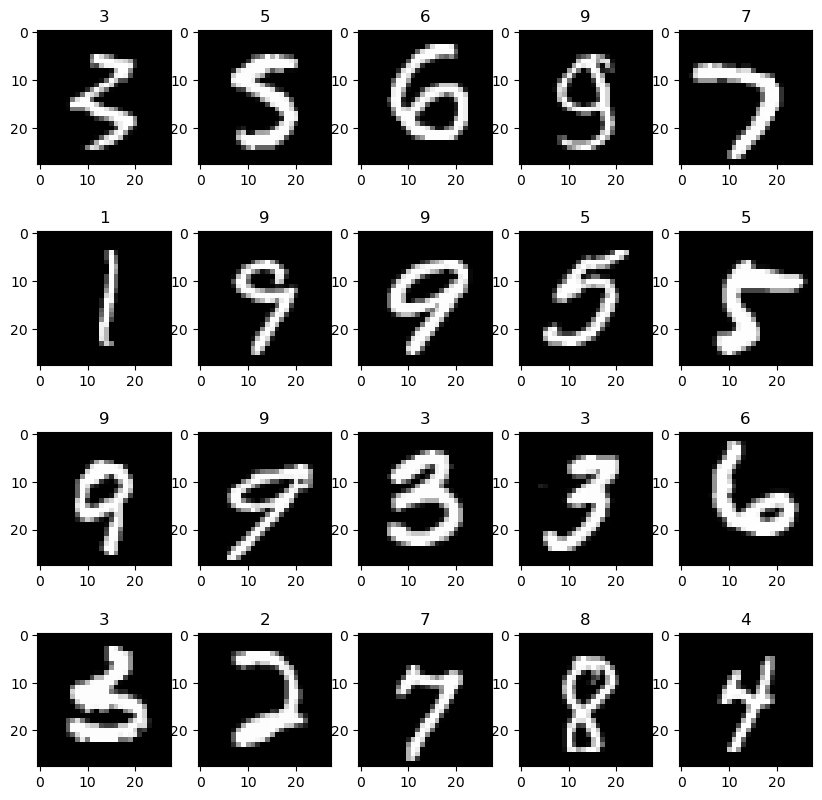

In [7]:
# train data 확인
plt.figure(figsize=(10, 10))

for i in range(20):
    image = train_dataset[i][0].squeeze().numpy()
    label = train_dataset[i][1]

    ax = plt.subplot(4, 5, i+1)
    plt.imshow(image, cmap='gray')
    plt.title(label)

### dataloader

In [8]:
batch_size = 32

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_dataloader = torch.utils.data.DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [9]:
for images, labels in train_dataloader:
    print(images.shape)
    print(labels)
    break

torch.Size([32, 1, 28, 28])
tensor([5, 2, 6, 3, 4, 2, 6, 8, 2, 5, 2, 6, 6, 6, 3, 3, 3, 3, 4, 1, 2, 8, 5, 4,
        9, 7, 8, 3, 2, 3, 2, 0])


## Model 생성

In [15]:
class Model(torch.nn.Module):
    def __init__(self):
        super().__init__()

        self.layer = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, padding=1, stride=1),
            torch.nn.ReLU(True),
            torch.nn.BatchNorm2d(num_features=16),
            torch.nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1, stride=1),
            torch.nn.ReLU(True),
            torch.nn.BatchNorm2d(num_features=32),
            torch.nn.AdaptiveMaxPool2d(output_size=(7,7)),
            torch.nn.Flatten(),
            torch.nn.Linear(7*7*32, 512),
            torch.nn.ReLU(True),
            torch.nn.Linear(512, 10),
            torch.nn.LogSoftmax(dim=1)
        )

    def forward(self, x):
        output = self.layer(x)

        return output

In [16]:
model = Model()
print(summary(model, input_size=(1, 28, 28)))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 28, 28]             160
              ReLU-2           [-1, 16, 28, 28]               0
       BatchNorm2d-3           [-1, 16, 28, 28]              32
            Conv2d-4           [-1, 32, 28, 28]           4,640
              ReLU-5           [-1, 32, 28, 28]               0
       BatchNorm2d-6           [-1, 32, 28, 28]              64
 AdaptiveMaxPool2d-7             [-1, 32, 7, 7]               0
           Flatten-8                 [-1, 1568]               0
            Linear-9                  [-1, 512]         803,328
             ReLU-10                  [-1, 512]               0
           Linear-11                   [-1, 10]           5,130
       LogSoftmax-12                   [-1, 10]               0
Total params: 813,354
Trainable params: 813,354
Non-trainable params: 0
-------------------------------

## Model 학습 함수
- training
- evaluation
- training_loop

In [42]:
def training(model, train_dataloader, train_dataset, criterion, optimizer):
    model. train()
    train_loss = 0.0
    train_accuracy = 0

    tbar = tqdm(train_dataloader)
    for images, labels in tbar:
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        max_prob, predicted = torch.max(outputs, 1)
        train_accuracy += (predicted == labels).sum().item() # tensor(~) 형태로 되어있어서 .item()을 통해서 실제 값을 뽑아서 사용한다.

    train_loss = train_loss / len(train_dataloader)
    train_accuracy = train_accuracy / len(train_dataset)

    return model, train_loss, train_accuracy

def evaluation(model, valid_dataloader, valid_dataset, criterion):
    model.eval()
    valid_loss = 0.0
    valid_accuracy = 0

    tbar = tqdm(valid_dataloader)
    with torch.no_grad():
        for images, labels in tbar:
            outputs = model(images)
            loss = criterion(outputs, labels)

            valid_loss += loss.item()
            max_prob, predicted = torch.max(outputs, 1)
            valid_accuracy += (predicted == labels).sum().item()

    valid_loss = valid_loss / len(valid_dataloader)
    valid_accuracy = valid_accuracy / len(valid_dataset)

    return model, valid_loss, valid_accuracy

def training_loop(model, train_dataloader, valid_dataloader, train_dataset, valid_dataset, criterion, optimizer, num_eopchs):
    for epoch in range(num_eopchs):
        model, train_loss, train_accuracy = training(model, train_dataloader, train_dataset, criterion, optimizer)
        model, valid_loss, valid_accuracy = evaluation(model, valid_dataloader, valid_dataset, criterion)

        print(f'Train Loss: {train_loss}, Train Accuracy: {train_accuracy}')
        print(f'Valid Loss: {valid_loss}, Valid Accuracy: {valid_accuracy}')

    return model

## Model 테스트
- test

In [57]:
def test(model, test_dataloader):
    model.eval()
    total_labels = []
    total_preds = []

    with torch.no_grad():
        tbar = tqdm(test_dataloader)
        for images, labels in tbar:
            outputs = model(images)

            max_prob, predicted = torch.max(outputs, 1)

            total_preds.extend(predicted.tolist())
            total_labels.extend(labels.tolist())

    total_preds = total_preds
    total_labels = total_labels

    return total_preds, total_labels

## Augmentation 없이 모델 학습

In [63]:
model_1 =Model()

criterion = torch.nn.NLLLoss() # Loss function
optimizer = torch.optim.Adam(model.parameters(), lr=0.001) # 최적화 함수

model = training_loop(model, train_dataloader, valid_dataloader, train_dataset, valid_dataset, criterion, optimizer, 10) # 학습

  0%|          | 0/1200 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

Train Loss: 0.012204960349720458, Train Accuracy: 0.9976041666666666
Valid Loss: 0.08948424881390944, Valid Accuracy: 0.9897916666666666


  0%|          | 0/1200 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

Train Loss: 0.011057909119985417, Train Accuracy: 0.9975260416666667
Valid Loss: 0.09162773957702278, Valid Accuracy: 0.9890625


  0%|          | 0/1200 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

Train Loss: 0.009420339033943579, Train Accuracy: 0.99796875
Valid Loss: 0.10274482891646453, Valid Accuracy: 0.9892708333333333


  0%|          | 0/1200 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

Train Loss: 0.01002309950855492, Train Accuracy: 0.9981770833333333
Valid Loss: 0.08116752185422081, Valid Accuracy: 0.9895833333333334


  0%|          | 0/1200 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

Train Loss: 0.008146492029419127, Train Accuracy: 0.997890625
Valid Loss: 0.07889632180968431, Valid Accuracy: 0.9903125


  0%|          | 0/1200 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

Train Loss: 0.0035910347093412055, Train Accuracy: 0.999140625
Valid Loss: 0.07432372897092708, Valid Accuracy: 0.9927083333333333


  0%|          | 0/1200 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

Train Loss: 0.009116775840583223, Train Accuracy: 0.9980729166666666
Valid Loss: 0.10037604424509294, Valid Accuracy: 0.9896875


  0%|          | 0/1200 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

Train Loss: 0.004559632688084683, Train Accuracy: 0.9987760416666667
Valid Loss: 0.08292349844658795, Valid Accuracy: 0.9904166666666666


  0%|          | 0/1200 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

Train Loss: 0.007470072107372655, Train Accuracy: 0.9983072916666667
Valid Loss: 0.09777023558028465, Valid Accuracy: 0.99


  0%|          | 0/1200 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

Train Loss: 0.007575870992631824, Train Accuracy: 0.9987239583333334
Valid Loss: 0.11096717669606476, Valid Accuracy: 0.9884375


In [64]:
total_preds, total_labels = test(model, test_dataloader)
acc_score = accuracy_score(total_preds, total_labels)
acc_score

  0%|          | 0/313 [00:00<?, ?it/s]

0.9874

# Augmentation 후 모델 학습
### image data Augmentation
- Random Horiaontal Flip : 이미지를 좌우로 무작위로 뒤집는다.
- Random Vertical Flip : 이미지를 상하로 무작위로 뒤집는다.
- Random Rotation : 이미지를 무작위로 회전시킨다.
- Color Jitter : 이미지의 밝기, 대비, 채도, 색상을 무작위로 변화시킨다.
- Random Crop : 이미지를 무작위로 잘라낸다.
- Normaliaztion : 이미지의 픽셀값을 정규화한다.

In [360]:
aug_transform = T.Compose([
    #T.RandomHorizontalFlip(p=0.5), # 이미지를 수평으로 뒤집는다.
    #T.RandomVerticalFlip(p=0.5), # 이미지를 수직으로 뒤집는다.
    #T.RandomRotation(degrees=45), # 이미를 -45 ~ 45도 사이로 회전한다.
    T.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.5), # 밝기, 대비, 채도, 색조 조절
    T.RandomResizedCrop(size=(28, 28), scale=(0.05, 10.0)), # 랜덤 크롭 후 크기 조절 -> scale=(a, b) -> a ~ b사이에서 크롭
    #T.Normalize(mean=[0.5], std=[0.5]),
    #T.Resize((28, 28)),
    T.ToTensor()
])

In [361]:
# 데이터 다운로드
download_root = './MNIST_DATASET'

train_dataset = torchvision.datasets.MNIST(download_root, transform=aug_transform, train=True, download=True)
test_dataset = torchvision.datasets.MNIST(download_root, transform=transform, train=False, download=True)

# train, validation 데이터 분할
total_size = len(train_dataset)
train_num, valid_num = int(total_size*0.8), int(total_size*0.2)
print('Train dataset 개수: {}'.format(train_num))
print('Valid dataset 개수: {}'.format(valid_num))
train_dataset, valid_dataset = torch.utils.data.random_split(train_dataset, [train_num, valid_num])

batch_size = 32

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_dataloader = torch.utils.data.DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

Train dataset 개수: 48000
Valid dataset 개수: 12000


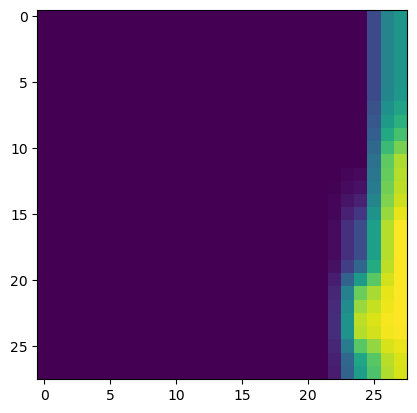

In [383]:
plt.imshow(valid_dataset[0][0].squeeze().numpy())

In [384]:
model_2 = Model()

criterion = torch.nn.NLLLoss()
optimizer = torch.optim.Adam(model_2.parameters(), lr=0.001)

model_2 = training_loop(model_2, train_dataloader, valid_dataloader, train_dataset, valid_dataset, criterion, optimizer, 10)

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/375 [00:00<?, ?it/s]

Train Loss: 0.6535626767650247, Train Accuracy: 0.7861875
Valid Loss: 0.47925802842775983, Valid Accuracy: 0.8406666666666667


  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/375 [00:00<?, ?it/s]

Train Loss: 0.4560972407733401, Train Accuracy: 0.8489166666666667
Valid Loss: 0.4246450882355372, Valid Accuracy: 0.8605


  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/375 [00:00<?, ?it/s]

Train Loss: 0.4132844706873099, Train Accuracy: 0.8626041666666666
Valid Loss: 0.40396519313255946, Valid Accuracy: 0.869


  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/375 [00:00<?, ?it/s]

Train Loss: 0.3859280494327346, Train Accuracy: 0.8725
Valid Loss: 0.386599676767985, Valid Accuracy: 0.8685833333333334


  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/375 [00:00<?, ?it/s]

Train Loss: 0.3675830820960303, Train Accuracy: 0.8779583333333333
Valid Loss: 0.3609245524605115, Valid Accuracy: 0.8785833333333334


  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/375 [00:00<?, ?it/s]

Train Loss: 0.35489458486934505, Train Accuracy: 0.8815833333333334
Valid Loss: 0.35704774409532547, Valid Accuracy: 0.8835


  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/375 [00:00<?, ?it/s]

Train Loss: 0.3456918398067355, Train Accuracy: 0.8846666666666667
Valid Loss: 0.3470558984577656, Valid Accuracy: 0.8818333333333334


  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/375 [00:00<?, ?it/s]

Train Loss: 0.33464294260243577, Train Accuracy: 0.8881666666666667
Valid Loss: 0.3291210904518763, Valid Accuracy: 0.8908333333333334


  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/375 [00:00<?, ?it/s]

Train Loss: 0.3298521540537477, Train Accuracy: 0.8889791666666667
Valid Loss: 0.33632933456202346, Valid Accuracy: 0.88575


  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/375 [00:00<?, ?it/s]

Train Loss: 0.3235140990658353, Train Accuracy: 0.8906041666666666
Valid Loss: 0.3331963219344616, Valid Accuracy: 0.8881666666666667


In [385]:
aug_total_preds, aug_total_labels = test(model_2, test_dataloader)

  0%|          | 0/313 [00:00<?, ?it/s]

In [387]:
aug_acc_score = accuracy_score(aug_total_preds, aug_total_labels)
aug_acc_score

0.9881